<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# 🛍️ Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products will sell more. 

## 📚 Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

In [1]:
import numpy as np      
import pandas as pd     

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [2]:
# YOUR CODE HERE
past = pd.read_csv('../dat/past.csv.gz')

In [3]:
# let's take a look at the data:
past.head(12)

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category
0,5866936,5.618978e+08,1.333333,1.333333,5.550000e+03,15.84000,15.84000,0.000000,1.333333,0.000000,...,0.000000,0.000000,0.0,0.666667,0.333333,0.000000,0.000000,0,0.000000,1.000000
1,5647110,5.326529e+08,2.250000,1.500000,2.755650e+04,5.80000,5.56500,1.250000,0.250000,0.250000,...,0.250000,0.750000,0.0,0.000000,0.250000,0.000000,0.000000,0,0.000000,1.000000
2,5790472,4.578109e+08,1.000000,1.000000,0.000000e+00,6.27250,6.27250,0.250000,0.750000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.750000,0.250000,0.000000,0,0.000000,1.000000
3,5811598,4.612641e+08,1.500000,1.500000,1.315325e+05,5.56000,5.56000,0.250000,1.000000,0.250000,...,0.250000,0.000000,0.0,0.000000,0.500000,0.000000,0.250000,0,0.250000,1.000000
4,5846363,5.157993e+08,1.875000,1.375000,1.105588e+04,4.08625,4.08625,0.500000,1.000000,0.250000,...,0.250000,0.375000,0.0,0.125000,0.250000,0.250000,0.000000,1,0.000000,1.000000
5,5826406,5.040005e+08,4.000000,3.333333,1.016038e+06,5.56000,5.50000,0.333333,2.666667,0.666667,...,0.333333,0.333333,0.0,0.333333,0.333333,0.000000,0.000000,0,0.000000,0.666667
6,5550698,5.744890e+08,1.454545,1.090909,5.469909e+03,4.41000,4.41000,0.272727,0.909091,0.090909,...,0.272727,0.181818,0.0,0.181818,0.454545,0.090909,0.090909,1,0.000000,1.000000
7,5787920,4.994029e+08,1.000000,1.000000,0.000000e+00,4.76000,4.76000,0.500000,0.000000,0.500000,...,0.000000,0.000000,0.0,0.500000,0.500000,0.000000,0.000000,0,0.000000,1.000000
8,5824146,3.815759e+08,2.800000,1.600000,1.725962e+05,4.88800,4.77600,1.000000,0.800000,0.800000,...,0.000000,0.200000,0.0,0.400000,0.400000,0.000000,0.000000,1,0.000000,1.600000
9,5695916,5.929000e+08,1.000000,1.000000,0.000000e+00,1.43000,1.43000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0,0.000000,1.000000


In [4]:
past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            5000 non-null   int64  
 1   user_id               5000 non-null   float64
 2   NumOfEventsInJourney  5000 non-null   float64
 3   NumSessions           5000 non-null   float64
 4   interactionTime       5000 non-null   float64
 5   maxPrice              5000 non-null   float64
 6   minPrice              5000 non-null   float64
 7   NumCart               5000 non-null   float64
 8   NumView               5000 non-null   float64
 9   NumRemove             5000 non-null   float64
 10  InsessionCart         5000 non-null   float64
 11  InsessionView         5000 non-null   float64
 12  InsessionRemove       5000 non-null   float64
 13  Weekend               5000 non-null   float64
 14  Fr                    5000 non-null   float64
 15  Mon                  

In [5]:
past.nunique()

product_id              5000
user_id                 4981
NumOfEventsInJourney     487
NumSessions              323
interactionTime         3429
maxPrice                2117
minPrice                2255
NumCart                  382
NumView                  405
NumRemove                349
InsessionCart           1542
InsessionView           1350
InsessionRemove         1515
Weekend                    1
Fr                       202
Mon                      200
Sat                      194
Sun                      208
Thu                      202
Tue                      208
Wed                      208
2019                     283
2020                     283
Jan                      241
Feb                      237
Oct                      241
Nov                      232
Dec                      215
Afternoon                223
Dawn                     161
EarlyMorning             222
Evening                  230
Morning                  215
Night                    172
Purchased?    

In [6]:
past.describe(include='all')

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category
count,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,5.573727e+06,5.235286e+08,1.951080,1.327052,2.490234e+05,7.457600,7.426321,0.541953,0.893687,0.413592,...,0.169931,0.213311,0.065900,0.162676,0.244012,0.169207,0.085550,0.343800,0.059343,1.143728
std,1.161840e+06,5.998702e+07,1.324727,0.718266,6.920382e+05,11.883206,11.876266,0.565350,0.841036,0.772170,...,0.255599,0.275556,0.172911,0.246050,0.289270,0.252342,0.191101,0.475023,0.153912,0.438141
min,4.104000e+03,6.524181e+07,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.760491e+06,4.998498e+08,1.000000,1.000000,0.000000e+00,2.483750,2.480000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.830816e+06,5.343735e+08,1.750000,1.166667,3.626375e+03,4.440585,4.440000,0.500000,1.000000,0.222222,...,0.000000,0.142857,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.875312e+06,5.616843e+08,2.308355,1.500000,2.071993e+05,7.620000,7.550000,0.858766,1.000000,0.632775,...,0.250000,0.333333,0.040000,0.250000,0.363636,0.250000,0.090909,1.000000,0.041888,1.045996
max,5.932538e+06,6.220262e+08,40.000000,28.000000,1.087537e+07,236.510000,236.510000,12.000000,28.000000,38.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?
    
    From the perspective of classification, is the data balanced?

In [7]:
# YOUR CODE HERE
past['Purchased?'].mean()

0.3438

### _Answer:_  
*  _What percentage of the interactions (rows) resulted in a purchase?_  
___Ans:___ About 34.4% of interactions (rows) resulted in a Purchase.  


*  _Do people mostly buy what they look at or do they do a lot of "window  
shopping" (shopping around without buying)?_  
___Ans:___ Roughly speaking, ~⅔ interactions don't result in a purchase and  
can be thought of as an estimate of "window shopping." Formally speaking,  
however, since we're not taking into account the specific events of an interaction's  
"journey," it is likely that the total number of product views in the above  
dataframe of 5,000 interactions (whether resulting in a purchase or not) is  
_greater than_ 5,000 ⇒ our estimate of ~⅔ interactions representing  
"windows shopping" is a _lower bound estimate_ if we define:  
    `window shopping = Σ (# product purchases) / Σ (# product views)`

  
*  _From the perspective of classification, is the data balanced?_  
___Ans:___ The above data indicate that for the the binary outcome  
not-purchased vs. purchased, the ratio of not-purchased to purchased  
for the given interactions is about 2:1 (⅔ : ⅓), which is not  
grossly imbalanced.

3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [8]:
X = past.drop(columns=['user_id', 'product_id'])
y = X.pop('Purchased?')

In [9]:
X.head(12)

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,InsessionCart,InsessionView,...,Nov,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Category
0,1.333333,1.333333,5.550000e+03,15.84000,15.84000,0.000000,1.333333,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.0,0.666667,0.333333,0.000000,0.000000,0.000000,1.000000
1,2.250000,1.500000,2.755650e+04,5.80000,5.56500,1.250000,0.250000,0.250000,3.750000,2.250000,...,0.250000,0.250000,0.750000,0.0,0.000000,0.250000,0.000000,0.000000,0.000000,1.000000
2,1.000000,1.000000,0.000000e+00,6.27250,6.27250,0.250000,0.750000,0.000000,17.250000,30.000000,...,0.250000,0.000000,0.000000,0.0,0.000000,0.750000,0.250000,0.000000,0.000000,1.000000
3,1.500000,1.500000,1.315325e+05,5.56000,5.56000,0.250000,1.000000,0.250000,3.250000,10.500000,...,0.250000,0.250000,0.000000,0.0,0.000000,0.500000,0.000000,0.250000,0.250000,1.000000
4,1.875000,1.375000,1.105588e+04,4.08625,4.08625,0.500000,1.000000,0.250000,4.875000,3.375000,...,0.250000,0.250000,0.375000,0.0,0.125000,0.250000,0.250000,0.000000,0.000000,1.000000
5,4.000000,3.333333,1.016038e+06,5.56000,5.50000,0.333333,2.666667,0.666667,8.000000,4.000000,...,0.000000,0.333333,0.333333,0.0,0.333333,0.333333,0.000000,0.000000,0.000000,0.666667
6,1.454545,1.090909,5.469909e+03,4.41000,4.41000,0.272727,0.909091,0.090909,4.818182,3.636364,...,0.000000,0.272727,0.181818,0.0,0.181818,0.454545,0.090909,0.090909,0.000000,1.000000
7,1.000000,1.000000,0.000000e+00,4.76000,4.76000,0.500000,0.000000,0.500000,14.000000,45.500000,...,1.000000,0.000000,0.000000,0.0,0.500000,0.500000,0.000000,0.000000,0.000000,1.000000
8,2.800000,1.600000,1.725962e+05,4.88800,4.77600,1.000000,0.800000,0.800000,10.800000,20.600000,...,0.600000,0.000000,0.200000,0.0,0.400000,0.400000,0.000000,0.000000,0.000000,1.600000
9,1.000000,1.000000,0.000000e+00,1.43000,1.43000,0.000000,1.000000,0.000000,10.000000,7.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [10]:
y.head(12)

0     0
1     0
2     0
3     0
4     1
5     0
6     1
7     0
8     1
9     0
10    0
11    0
Name: Purchased?, dtype: int64

In [11]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to a numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

### _Answer:_  
As Sebastian Raschka points out, while mean-centering does not affect the  
covariance matrix, both feature scaling and standardization (μ = 0, σ = 1) ___do___.

In [12]:
X_scaled = StandardScaler().fit_transform(X)

In [13]:
print(type(X_scaled))

<class 'numpy.ndarray'>


In [14]:
# take a look at X_scaled:
print(X_scaled.shape)

(5000, 34)


In [15]:
pca = PCA(n_components=5, random_state=0, whiten=True)
X_reduced = pca.fit_transform(X_scaled)

In [16]:
assert X_reduced.shape == (5000, 5)

In [17]:
# take a look at X_reduced:
print(X_reduced)

[[ 0.30573678 -0.9487725   0.7263802  -0.0056057   0.46399657]
 [ 0.24375752  0.0110209  -0.41861686  0.14278212  0.61985593]
 [-0.08544161 -0.65292073 -0.32903781 -0.33871745 -1.3222435 ]
 ...
 [ 1.15088908 -1.33359355 -0.68035111 -0.3685016   1.14465992]
 [ 1.34004268 -1.10104437 -0.69679521  0.23360385  1.80388222]
 [-1.32200205  0.19572472 -0.0068598  -0.48549957 -0.16829627]]


In [18]:
print(type(X_reduced))

<class 'numpy.ndarray'>


5. Print out the percentage of variance explained by each of the selected components.

In [19]:
# use explained_variance_ratio_ attribute:
exp_var_pca = pca.explained_variance_ratio_
print(exp_var_pca)

[0.10282299 0.09445816 0.06513061 0.05112375 0.04251041]


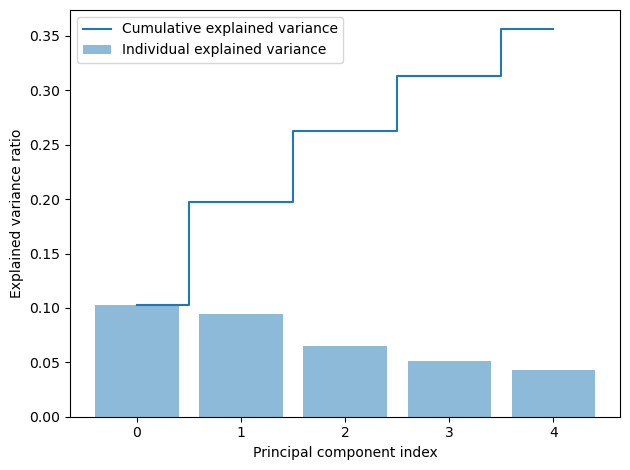

In [20]:
# calculate cumulative sum of eigenvalues:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [21]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [22]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

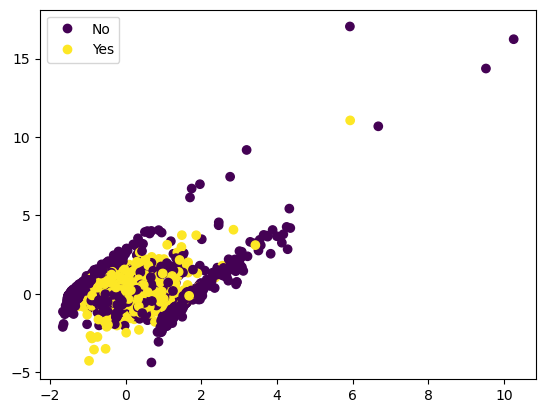

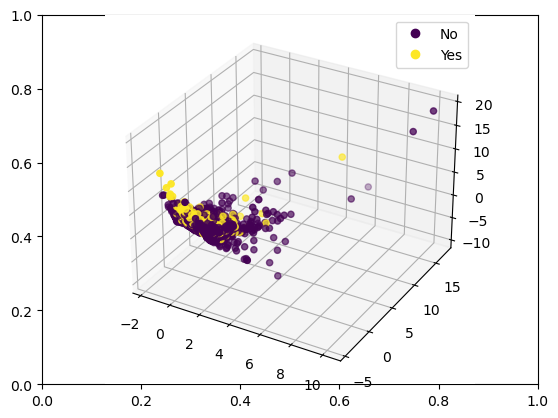

In [23]:
# YOUR CODE HERE
visualize_2pcs(X_reduced, y)
visualize_3pcs(X_reduced, y)

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( are the labels balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [24]:
# YOUR CODE HERE (imports!)

def train(X, y, standardize = True) -> None:
    # YOUR CODE HERE
    # train_test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    
    # apply logistic regression:
    if standardize:
        pipe = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
    else:
        pipe = make_pipeline(LogisticRegression(class_weight='balanced'))
        
    # fit pipeline using training data:
    pipe.fit(X_train, y_train)
    
    # make predictions:
    y_pred = pipe.predict(X_test)
    
    # print classification report on test data:
    target_names = ['no purchase', 'purchase']
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # plot confusion matrix:
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp.figure_.suptitle(f'Confusion Matrix, Logistic Regression,'
                          f'StandardScaler = {standardize}')
    print(f'Confusion Matrix:\n{disp.confusion_matrix}')
    
    plt.show()
    
    return

Now apply the pipeline on the all the features `X` and review the performance

              precision    recall  f1-score   support

 no purchase       0.98      0.40      0.57       649
    purchase       0.47      0.99      0.64       351

    accuracy                           0.61      1000
   macro avg       0.73      0.70      0.61      1000
weighted avg       0.81      0.61      0.60      1000

Confusion Matrix:
[[262 387]
 [  4 347]]


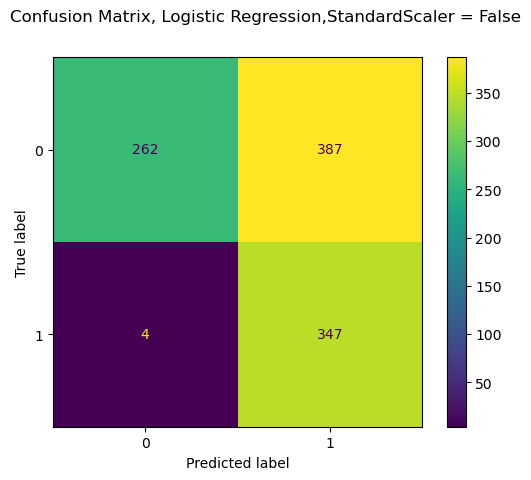

In [25]:
# let's apply pipeline on all features in X without standardization first:
train(X, y, standardize=False)

              precision    recall  f1-score   support

 no purchase       0.75      0.77      0.76       649
    purchase       0.55      0.52      0.54       351

    accuracy                           0.68      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.68      0.68      0.68      1000

Confusion Matrix:
[[500 149]
 [167 184]]


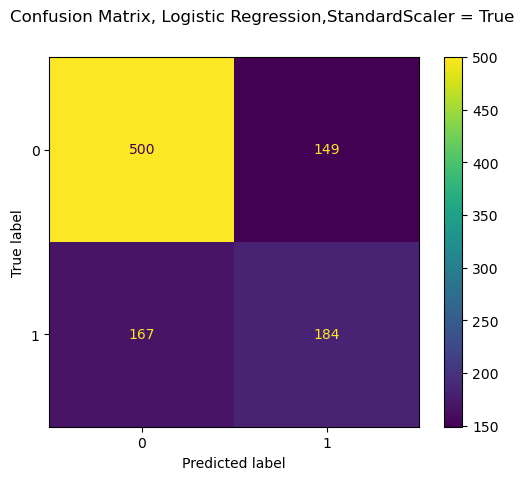

In [26]:
# now apply pipeline on all features in X with standardization:
train(X, y, standardize=True)

Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

              precision    recall  f1-score   support

 no purchase       0.74      0.70      0.72       649
    purchase       0.49      0.54      0.51       351

    accuracy                           0.64      1000
   macro avg       0.61      0.62      0.62      1000
weighted avg       0.65      0.64      0.65      1000

Confusion Matrix:
[[454 195]
 [162 189]]


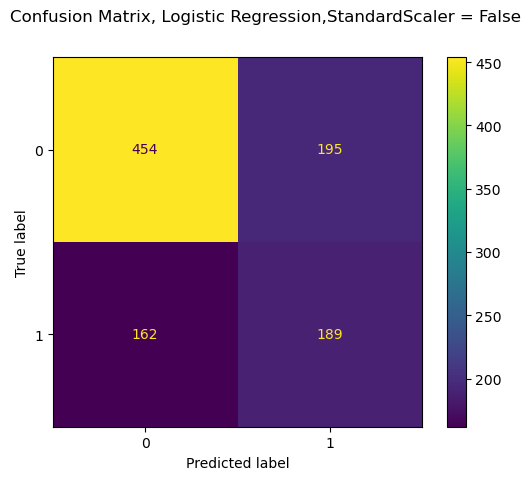

In [27]:
# when applying pipeline to X_reduced, don't need to standardize since
# we've already done that:
#     previously, X_reduced = pca.fit_transform(X_scaled), where
#     X_scaled = StandardScaler().fit_transform(X)
train(X_reduced, y, standardize=False)

              precision    recall  f1-score   support

 no purchase       0.74      0.70      0.72       649
    purchase       0.49      0.54      0.51       351

    accuracy                           0.64      1000
   macro avg       0.61      0.62      0.62      1000
weighted avg       0.65      0.64      0.65      1000

Confusion Matrix:
[[454 195]
 [162 189]]


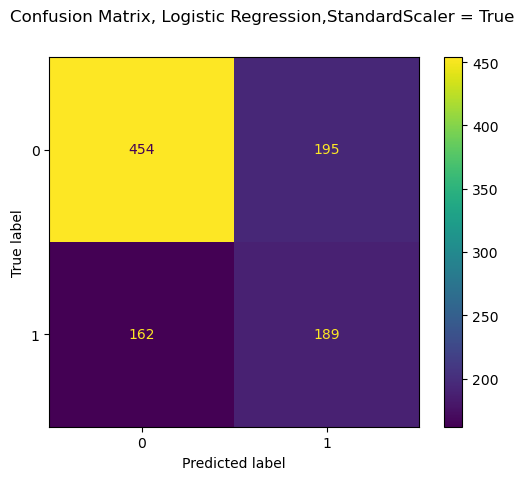

In [28]:
# let's compared with (re)-standardization anyway
train(X_reduced, y, standardize=True)

##### _OK that makes sense..._
_(standardizing X_reduced makes no difference since it's already been  
standardized)_

8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 
    *YOUR ANSWER HERE*

### _Answer:_  

If we compare the performance metrics obtained with logistic regression on the  
full dataset **X** with all features **retained & standardized**, to logistic  
regression on **X_reduced** (standardized, dimensionality reduced from 34 → 5  
principal components), then for the most part, logistic regression on the full  
dataset **X** does a little better than on **X_reduced**. 

Using PCA, we have achieved nearly identical model performance (in this  
specific comparison) while presumably reducing computational complexity (and  
generally speaking, overfitting). These results are somewhat surprising since  
the applied PCA (dim 34 → 5) cumulatively explains _only about 35% of the  
data's variance_; yet despite presumably significant information loss, its predictive  
performance doesn't seem to suffer much, at least in comparison to logistic  
regression applied to the scaled, full dataset **X** with all features retained.  

_(Perhaps a lot of the 'information' lost via PCA in this case actually  
represents 'noise' rather than anything substantively informative to the task of  
predicting purchases.)_

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on X, the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [29]:
# (already imported above)

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [30]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=10).fit(X)
        inertias.append(kmeans.inertia_)
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

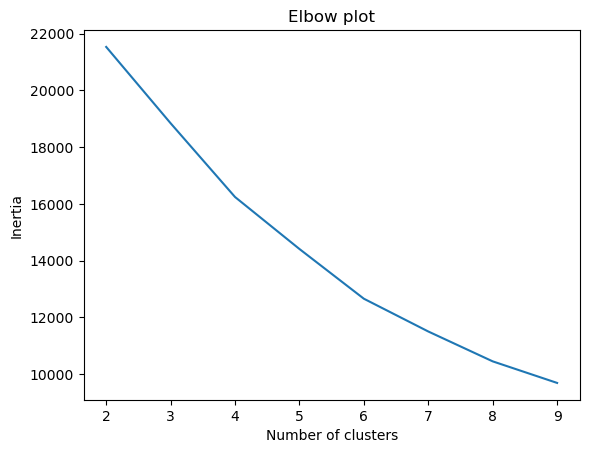

In [31]:
# define no. of centroids to test = 'ks':
ks = list(range(2,10))
visualize_elbow(X_reduced, ks)

4. What are the disadvantage to use the Elbow method? 

### _Answer:_  
The primary disadvantage of the Elbow method is that often, it is _not  
clear where the Elbow is (on the Elbow plot)!_ Deciding which k value gives  
sufficiently low inertia, such that the _even lower inertia_ associated with  
k+1 clusters represents _a diminishing return relative to model complexity  
(and/or reality),_ is indeed an inexact enterprise at best.

Obviously, when k = n, where n = # input samples, the distortion cost  
function = 0, but this model hasn't meaningfully clustered anything.    
Similarly, at the other extreme, when k = 1, the distortion  
cost function will be maximal, but also with nothing meaningfully clustered.  
The Elbow method represents a _subjective 'best guess'_ between these  
two extremes.

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [32]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.19919967382452838
For n_clusters = 3 The average silhouette_score is : 0.21238428422148686
For n_clusters = 4 The average silhouette_score is : 0.2184625984502988
For n_clusters = 5 The average silhouette_score is : 0.20550166021115696
For n_clusters = 6 The average silhouette_score is : 0.20861307391519499
For n_clusters = 7 The average silhouette_score is : 0.21374221383779582
For n_clusters = 8 The average silhouette_score is : 0.2181726891213164


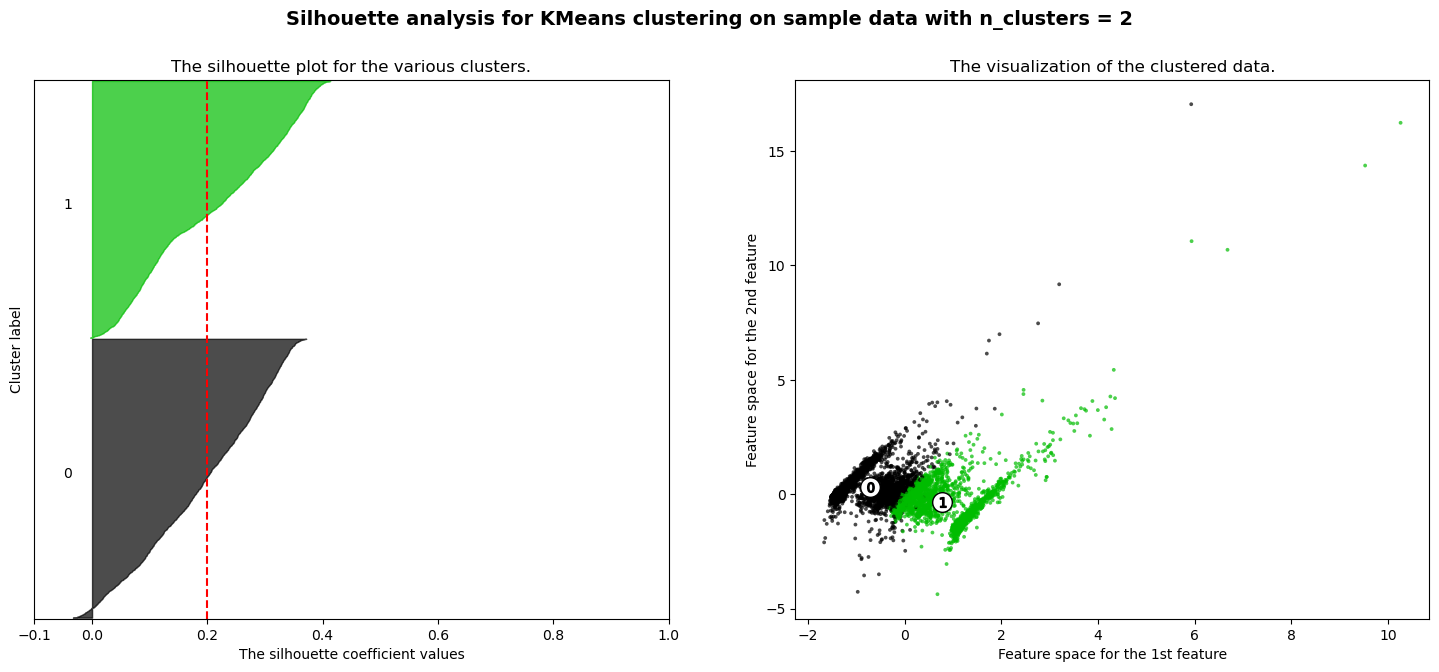

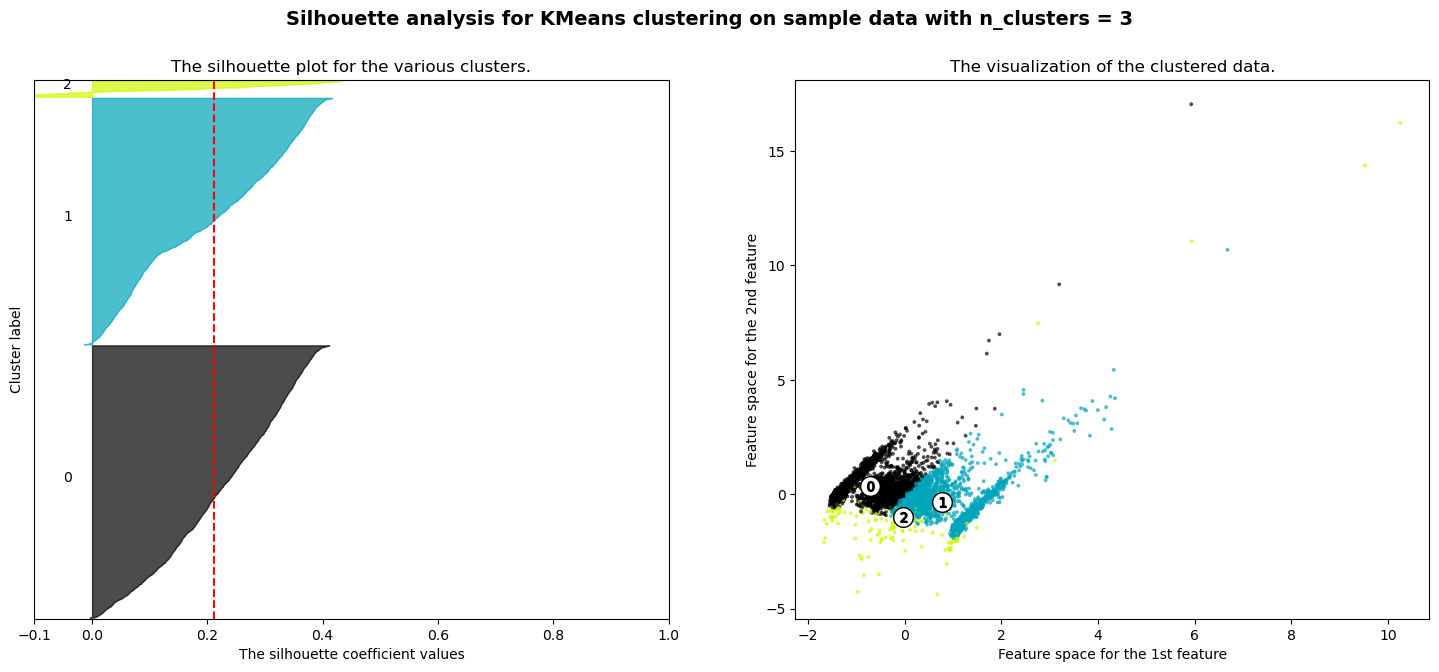

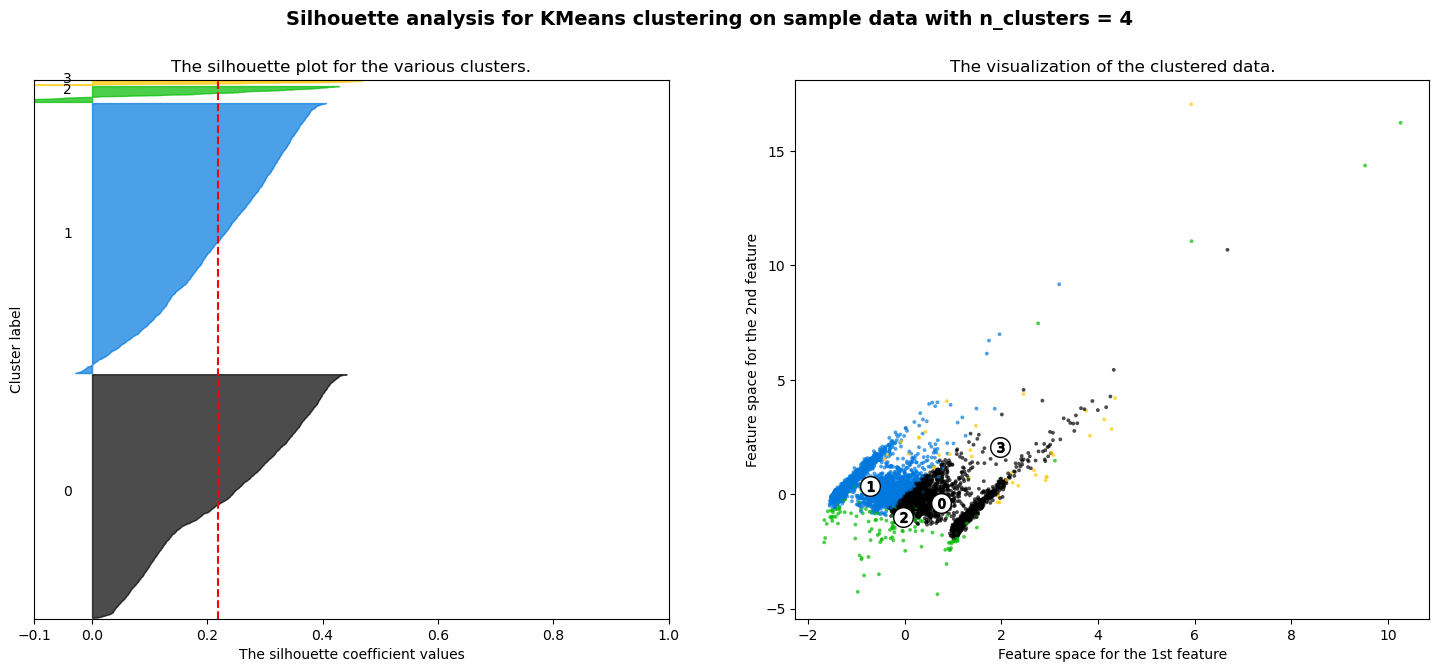

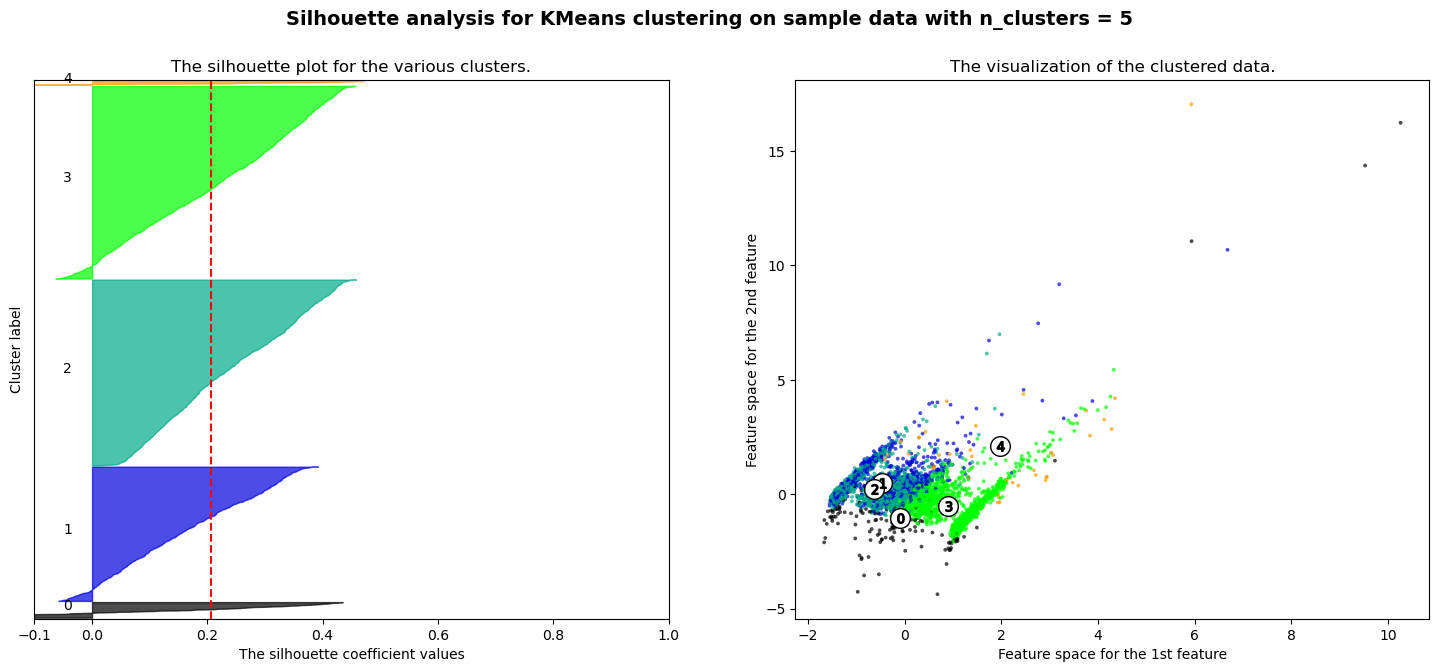

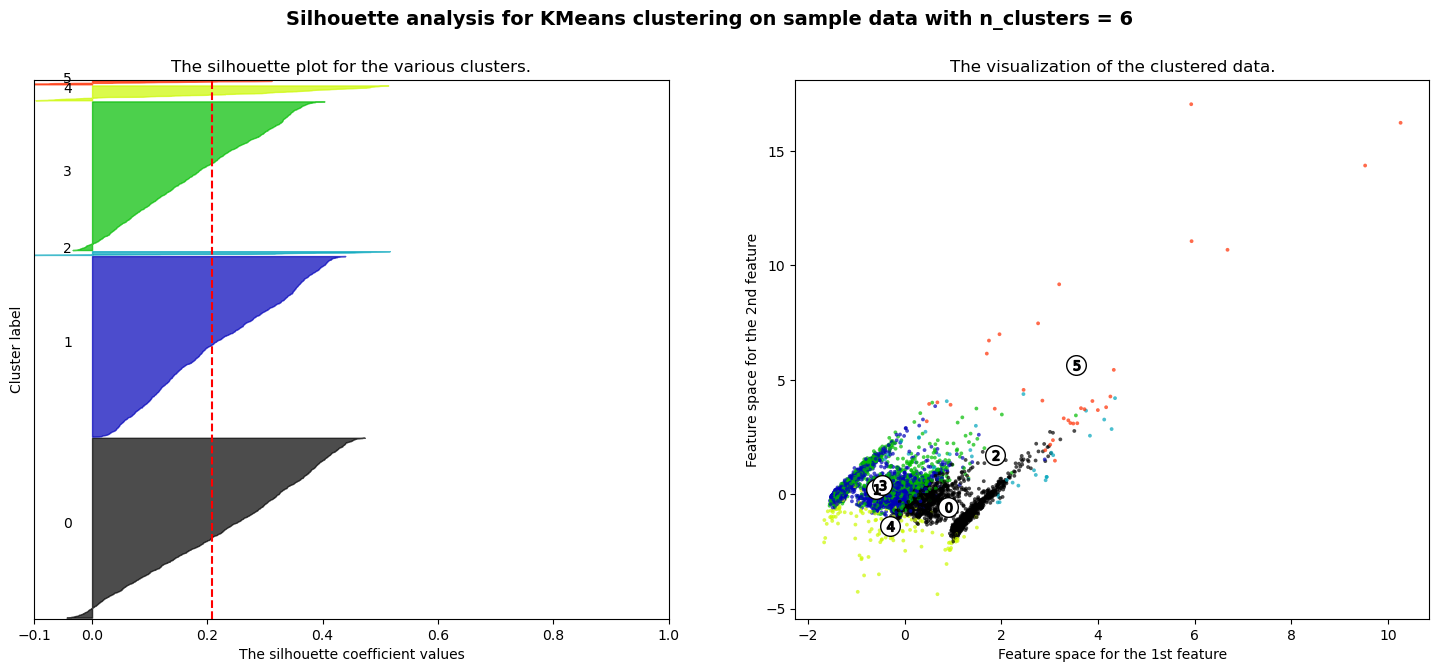

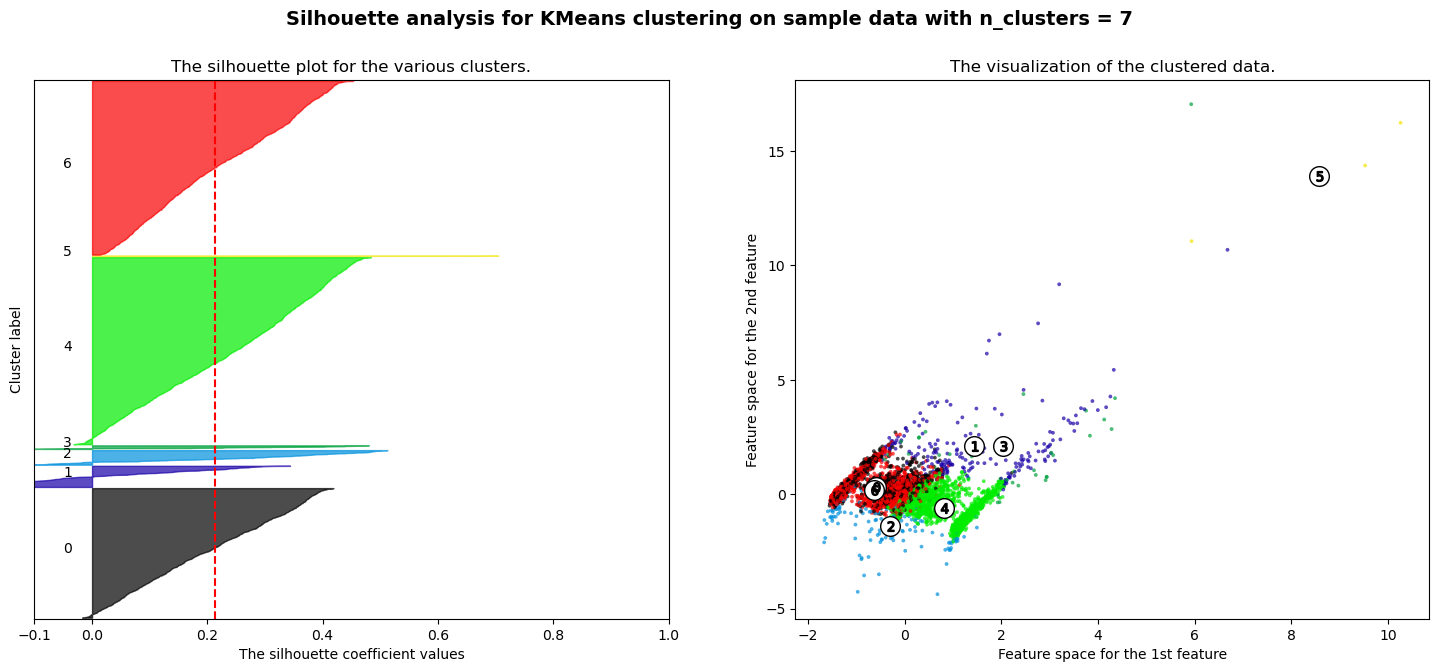

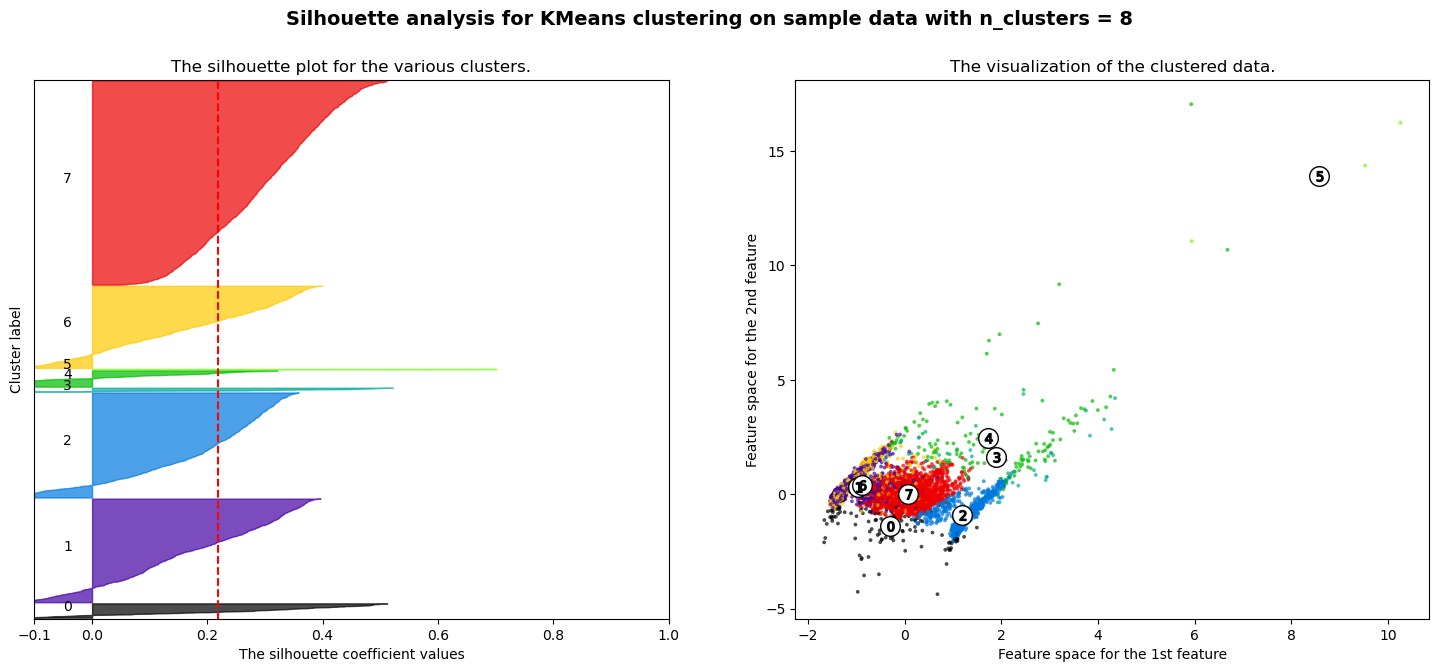

In [33]:
# recall that X_reduced is type numpy.ndarray
visualize_silhouette(8, X_reduced, 10)    # (parameters are max_clusters:int,
                                          #  X:np.ndarray,
                                          #  random_state:int=10)

6. Instantiate a k-means model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

### _NB: This is not a straightforward task!_  
From the above silhouette plots, it is not entirely obvious what k   
we should pick (The previous 'elbow plot' was similarly not straightforward  
to interpret.):

*  k = 8, 7, 6, or 4 seem suboptimal on the basis of cluster-size imbalance  
and/or v. negative silhouette coefficient values.  


* k = 2 seems overly simplistic (a subjective assertion to be sure!).  


* k = 3 seems overall quite imbalanced in cluster size, in addition to  
having v negative silhouette coefficients in the last group (2).  


* ___k = 5 is the only value remaining for consideration:___  
It arguably has:  
    *  better overall balance of cluster size (although clusters 0 or 4  
    are certainly smaller than the other 3, which are more comparable in size).  
    *  small slivers of v. negative silhouette coefficients only in 2 of the  
    5 clusters (0 & 4).  
    *  small slivers of mod. negative silhouette coefficients only in 2 of the  
    5 clusters (1 & 3).  
    *  overall silhouette score ≈ 0.21 comparable to the other scores  
  
  
*  _OK, that's a lot of handwaving--in the end, this is not an entirely objective,  
rigorously justifiable choice!_

In [34]:
# assign 'optimal' no. clusters from above to km & fit on X_reduced
km = 5

kmeans = KMeans(n_clusters=km, init='k-means++', n_init=10, random_state=10).fit(X_reduced)
print(kmeans.inertia_)

14407.441051566639


7. What is the size of each cluster? 

In [35]:
print(kmeans.labels_.shape)

(5000,)


In [36]:
# use pd to create df of cluster labels:
kmeans_labels = pd.DataFrame()
kmeans_labels['data_index'] = np.arange(kmeans.labels_.shape[0])
kmeans_labels['cluster'] = kmeans.labels_
kmeans_labels.head(12)

,data_index,cluster
0,0,3
1,1,1
2,2,2
3,3,2
4,4,2
5,5,1
6,6,2
7,7,2
8,8,2
9,9,3


In [37]:
# now, calculate cluster size:
kmeans_labels.groupby('cluster').count()

,data_index
cluster,
0,147
1,1261
2,1746
3,1809
4,37


8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [38]:
# extract "cluster" column from kmeans_labels df:
cluster_col = kmeans_labels['cluster']

# add extracted col of predicted cluster index to 'past' dataframe:
past_with_clusters = past.assign(cluster_pca=cluster_col)
past_with_clusters.head(12)

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
0,5866936,5.618978e+08,1.333333,1.333333,5.550000e+03,15.84000,15.84000,0.000000,1.333333,0.000000,...,0.000000,0.0,0.666667,0.333333,0.000000,0.000000,0,0.000000,1.000000,3
1,5647110,5.326529e+08,2.250000,1.500000,2.755650e+04,5.80000,5.56500,1.250000,0.250000,0.250000,...,0.750000,0.0,0.000000,0.250000,0.000000,0.000000,0,0.000000,1.000000,1
2,5790472,4.578109e+08,1.000000,1.000000,0.000000e+00,6.27250,6.27250,0.250000,0.750000,0.000000,...,0.000000,0.0,0.000000,0.750000,0.250000,0.000000,0,0.000000,1.000000,2
3,5811598,4.612641e+08,1.500000,1.500000,1.315325e+05,5.56000,5.56000,0.250000,1.000000,0.250000,...,0.000000,0.0,0.000000,0.500000,0.000000,0.250000,0,0.250000,1.000000,2
4,5846363,5.157993e+08,1.875000,1.375000,1.105588e+04,4.08625,4.08625,0.500000,1.000000,0.250000,...,0.375000,0.0,0.125000,0.250000,0.250000,0.000000,1,0.000000,1.000000,2
5,5826406,5.040005e+08,4.000000,3.333333,1.016038e+06,5.56000,5.50000,0.333333,2.666667,0.666667,...,0.333333,0.0,0.333333,0.333333,0.000000,0.000000,0,0.000000,0.666667,1
6,5550698,5.744890e+08,1.454545,1.090909,5.469909e+03,4.41000,4.41000,0.272727,0.909091,0.090909,...,0.181818,0.0,0.181818,0.454545,0.090909,0.090909,1,0.000000,1.000000,2
7,5787920,4.994029e+08,1.000000,1.000000,0.000000e+00,4.76000,4.76000,0.500000,0.000000,0.500000,...,0.000000,0.0,0.500000,0.500000,0.000000,0.000000,0,0.000000,1.000000,2
8,5824146,3.815759e+08,2.800000,1.600000,1.725962e+05,4.88800,4.77600,1.000000,0.800000,0.800000,...,0.200000,0.0,0.400000,0.400000,0.000000,0.000000,1,0.000000,1.600000,2
9,5695916,5.929000e+08,1.000000,1.000000,0.000000e+00,1.43000,1.43000,0.000000,1.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0,0.000000,1.000000,3


9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

### _Answer:_  
_OK, this is a complex task..._  
We can try to make the cluster analysis more tractable by noting the following:  
*  Ultimately, we are interested in the outcome, Purchase/No-Purchase.  
*  As before, product_id & user_id are unlikely to be informative in this regard.    
*  One of the arXiv papers referenced above (Roychowdhury et al.,  
_Categorizing Online Shopping Behavior from Cosmetics to Electronics: An   
Analytical Framework, in press_) notes the following:  
    *  No time-related features appeared to help in separating purchase/no-purchase  
    outcomes;    
    *  ___However, there were 5 major discriminatory features in this regard:___  
        *  total interaction time  
        *  no. events and sessions  
        *  no. views  
        *  avg time spent in session views  
        *  num carts  
        *  min-max price  
        *  more views and more time spent on viewing often implied customer   
        indecision resulting in no-purchasing  
    *  While the above may certainly _not generalize_ to our dataset, it can  
    serve as a useful starting point.  

In view of the above considerations, we proceed as follows:

In [39]:
past_with_clusters.head()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0,3
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0,1
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0,2
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0,2
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0,2


<AxesSubplot:xlabel='Purchased?'>

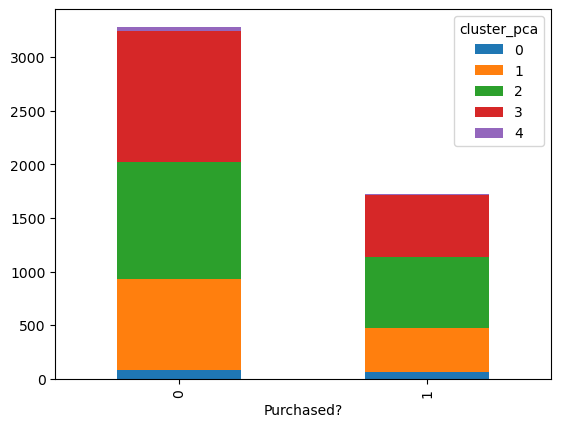

In [40]:
# Very simply, let's first check if the 5 kmeans clusters   
# discriminate between purchase outcome:

past_with_clusters.groupby('Purchased?')['cluster_pca'].value_counts().unstack().plot(kind='bar', stacked=True)


##### _...OK, nothing obvious above..._  
_I am deferring further EDA of our data with cluster assignments here (e.g.,  
correlation or attempting to identify features that discriminate amongst  
the assigned clusters) given that k-means does not appear to be a good  
approach in this case (see full answer below)._

10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

### _Answer:_  
_What are the assumptions for k-means?_  
__Ans:__ K-means is based on several restrictive assumptions about the data.  
These often limit its accuracy and interpretability when violated:    
*  The algorithm models data as lying _within a sphere_ around its assigned  
cluster centroid, where the sphere's radius _is identical in all dimensions(!)  
and all clusters have the identical radius(!)_
*  K-means' reliance on _Euclidean distance (a linear space)_ means that it  
doesn't handle outliers well.  
*  K-means also does not account for differences in _cluster density_, since  
it clusters data on the basis of closeness (as measured by Euclidean distance)  
to its centroid.  
*  While K-means _will always converge,_ it may arrive at a ___local, and not  
global minimum.___ (This is highly dependent on centroid initialization.)
*  K-means creates a situation in which the _distortion cost function (inertia)   
monotonically decreases_ with increasing cluster number. Therefore, there is  
no definitive way in which to choose the 'right' k.  

##### _In conclusion:_  
I don't think the above results are very meaningful: _Semi-garbage in, semi-garbage out!:_  
*  At the very start, the first 5 principal components only explained about ⅓ of  
our data's variance.   
*  Then, when applying K-means to `X_reduced`, it became apparent that there was   
_no clear, 'best' value for k_.  

___Future directions/recommendations:___ Although time does not permit, since our  
dataset includes ___mixed categorical and continuous data___, it might be worth  
trying ___factor analysis of mixed data (FAMD)___, which is a principal component  
method combining PCA for _continuous variables_ and ___multiple correspondence  
analysis (MCA)___ for _categorical variables._ Concretely, this could be tried  
in Python with the `prince` library from PyPI, which implements FAMD as well as  
provides a scikit-learn API.  

__References:__  
*  Raykov, YP _et al. What to Do When K-Means Clustering Fails: A simple yet  
principled alternative algorithm. PLos One_ __11__(9):e0162259 (2016).
*  Chelaru-Centeau, N. _Calculate principal components of mixed-type data_ (2019)  
https://nextjournal.com/pc-methods/calculate-pc-mixed-data  
*  `prince 0.7.1 (PyPI)`  
https://pypi.org/project/prince/#:~:text=Implementation%20%3A%3A%20PyPy-,Project%20description,with%20a%20scikit%2Dlearn%20API.  


In [41]:
# YOUR CODE HERE
# (see above)

11. Jot down recommendations or followup steps, detailing the reasons.

_(see above for answer)_

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [42]:
# read in new dataframe:
new = pd.read_csv('../dat/new.csv.gz')
new.shape

(30091, 5)

In [43]:
assert new.shape == (30091, 5)

In [44]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

### _Answer:_  

* The number of samples in `past` was 5,000; here in `new`, n = 30,091.  

* `test` has a lot fewer features (3 + 1 label) compared with `past` (36 + 1 label)

    *The number of datapoints in the training set is relatively small while the test set is quite large. The training set has more features than in the test set.*

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [45]:
# check for shared product ids in training & test:
pi_past = past['product_id'].to_numpy()
print(f'product_id of past has shape: {pi_past.shape}')

pi_new  =  new['product_id'].to_numpy()
print(f'product_id of new  has shape: {pi_new.shape}')

pi_shared = np.intersect1d(pi_past, pi_new)
print(pi_shared.shape)
print(pi_shared)

product_id of past has shape: (5000,)
product_id of new  has shape: (30091,)
(0,)
[]


##### _...:, no shared product ids in `past` and `new` dataframes_

4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [46]:
# calculate % purchases in test:
new['Purchased?'].mean()

0.3442557575354757

In [47]:
# we also need to look at the distribution of maxPrice, minPrice, &
# Category features in new:
new.describe(include='all')

,product_id,maxPrice,minPrice,Purchased?,Category
count,3.009100e+04,30091.000000,30091.000000,30091.000000,30091.000000
mean,5.590238e+06,7.715709,7.681662,0.344256,1.135825
std,1.121504e+06,13.044306,13.011201,0.475133,0.429911
min,3.752000e+03,0.000000,0.000000,0.000000,0.000000
25%,5.760772e+06,2.530149,2.519375,0.000000,1.000000
50%,5.831620e+06,4.520000,4.472857,0.000000,1.000000
75%,5.871056e+06,7.780000,7.780000,1.000000,1.000000
max,5.932595e+06,327.034545,327.034545,1.000000,4.000000


In [48]:
# let's compare these to the same features from past df:
past[['maxPrice', 'minPrice', 'Purchased?', 'Category']].describe(include='all')

,maxPrice,minPrice,Purchased?,Category
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,7.457600,7.426321,0.343800,1.143728
std,11.883206,11.876266,0.475023,0.438141
min,0.000000,0.000000,0.000000,0.000000
25%,2.483750,2.480000,0.000000,1.000000
50%,4.440585,4.440000,0.000000,1.000000
75%,7.620000,7.550000,1.000000,1.045996
max,236.510000,236.510000,1.000000,4.000000


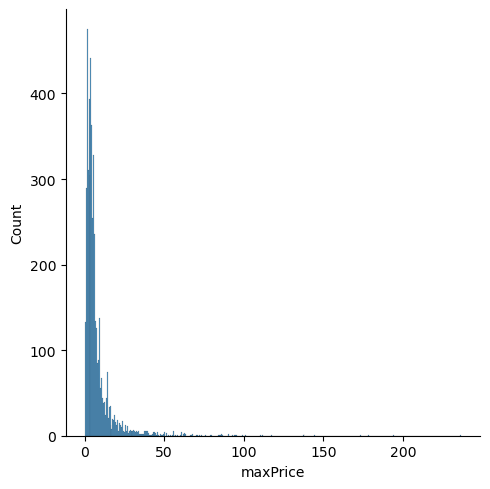

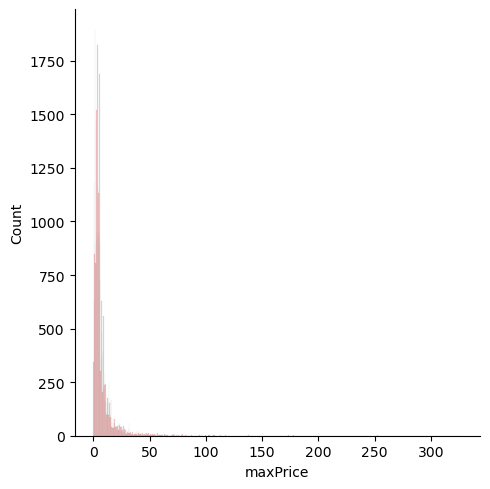

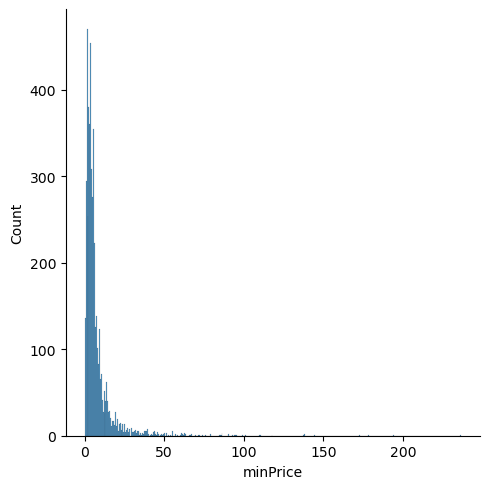

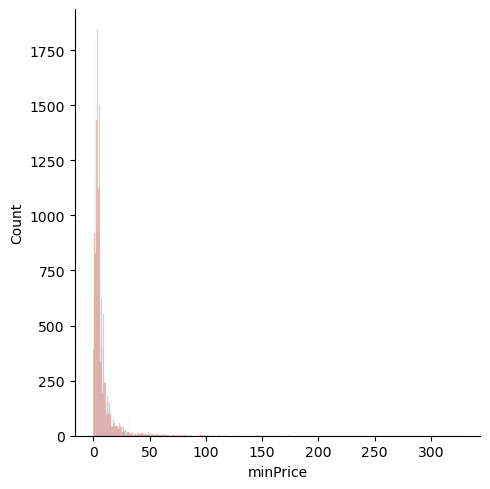

In [49]:
# now check the distributions of these features visually
# (past vs. new df's):
sns.displot(past['maxPrice'])
sns.displot( new['maxPrice'], color='red', alpha=0.2)

sns.displot(past['minPrice'])
sns.displot( new['minPrice'], color='red', alpha=0.2)

<AxesSubplot:xlabel='Category', ylabel='Count'>

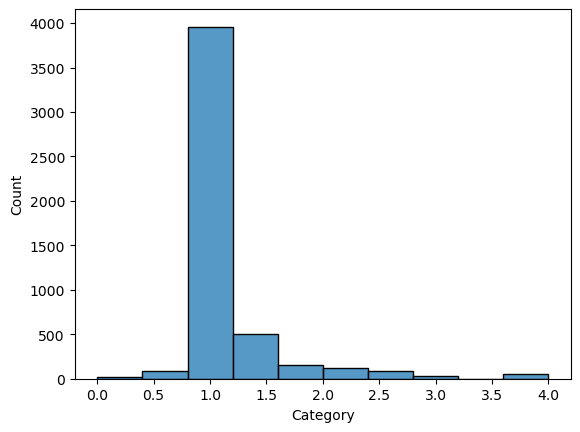

In [50]:
sns.histplot(past['Category'], bins=10)

<AxesSubplot:xlabel='Category', ylabel='Count'>

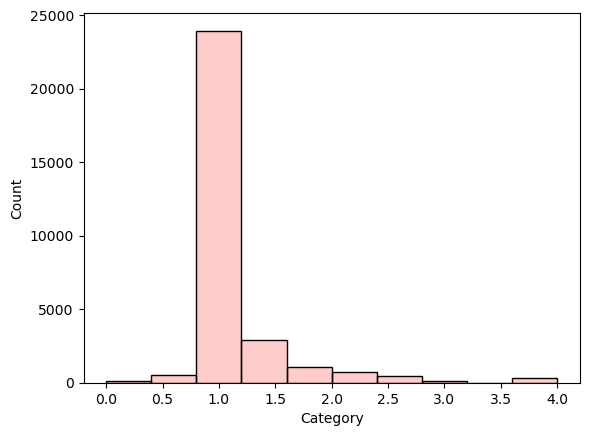

In [51]:
sns.histplot( new['Category'], bins=10, color='red', alpha=0.2)

<AxesSubplot:xlabel='Purchased?', ylabel='Count'>

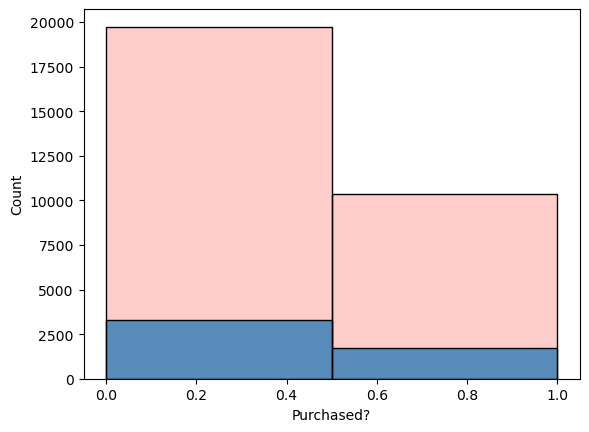

In [52]:
sns.histplot( new['Purchased?'], bins=2, color='red', alpha=0.2)
sns.histplot(past['Purchased?'], bins=2)


5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [53]:
# create ndarrays X_train, y_train:
X_train = past[['maxPrice', 'minPrice', 'Purchased?', 'Category']]
y_train = X_train.pop('Purchased?')
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

# create ndarrays X_test, y_test:
# drop product_id & pop as before:
X_test = new.drop(columns=['product_id'])
y_test = X_test.pop('Purchased?')
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# confirm data:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f'Ratio of test:train data = {X_test.shape[0]/X_train.shape[0]}')
print(type(X_train), type(X_test), type(y_train), type(y_test))
print(type(X_train).__module__, type(X_test).__module__, 
      type(y_train).__module__, type(y_test).__module__)

(5000, 3) (30091, 3) (5000,) (30091,)
Ratio of test:train data = 6.0182
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
numpy numpy numpy numpy


In [54]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

### _...Actually, before we do this:_  
Let's first see how well logistic regression (without standardization) does on   
_just the original data set of 5,000 samples using only our selected 3 features,_  
so that we have a 'baseline' for subsequent performance comparisons:

In [55]:
# generate subset of 'past' data containing all 5,000 samples but
# only our 3 selected features:
X_red = past[['maxPrice', 'minPrice', 'Purchased?', 'Category']]
y_red = X_red.pop('Purchased?')
print(X_red.shape, y_red.shape)

(5000, 3) (5000,)


              precision    recall  f1-score   support

 no purchase       0.77      0.92      0.84       649
    purchase       0.78      0.49      0.60       351

    accuracy                           0.77      1000
   macro avg       0.78      0.71      0.72      1000
weighted avg       0.77      0.77      0.76      1000

Confusion Matrix:
[[600  49]
 [178 173]]


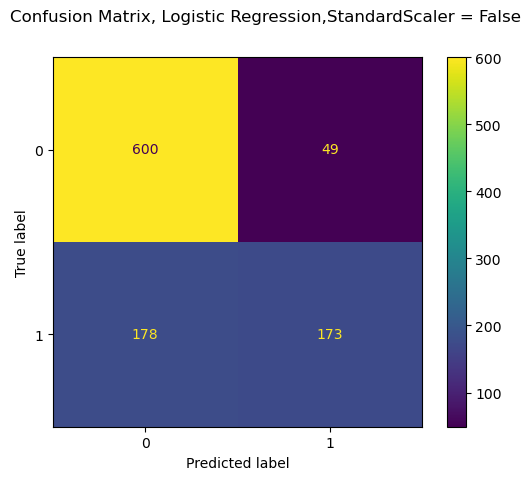

In [56]:
# now run simple logistic regression on a train/split of this 'reduced'
# 3-feature data using the pipeline defined above in function 'train':
train(X_red, y_red, standardize=False)

#### _...This is poor performance indeed:_  
We're interested in ***maximizing recall*** with regard to purchase  
prediction of new cosmetics so that they're _not understocked._ But  
even on our completely (although somewhat small) labeled original  
dataset, the logistic regression model does ***no better than random  
guessing*** at predicting purchases on products that _were in fact purchased  
(recall for purchase = 0.49: so actually slightly worse than random  
guessing!)_  

_This does not bode well for LabelSpreading (semi-supervised learning),  
since the above suggests that the limited 3 features we have for the new  
cosmetic products are likely not enough to meaningfully predict purchases._    

How about trying to see if ***standardizing the 3 input features*** from  
our original data set gives any improvement?

              precision    recall  f1-score   support

 no purchase       0.77      0.92      0.84       649
    purchase       0.78      0.50      0.61       351

    accuracy                           0.77      1000
   macro avg       0.78      0.71      0.72      1000
weighted avg       0.78      0.77      0.76      1000

Confusion Matrix:
[[600  49]
 [177 174]]


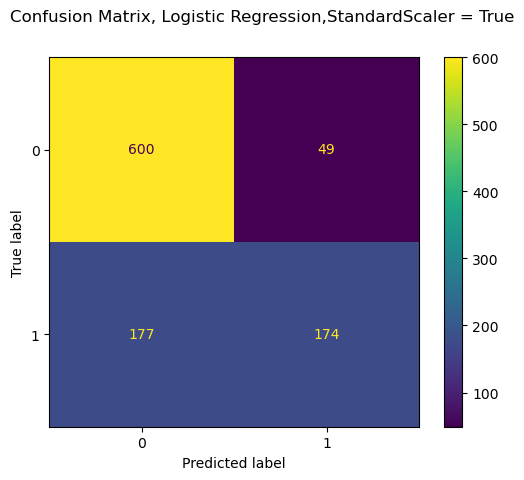

In [57]:
# re-run simple logistic regression on train/split of same 'reduced'
# 3-feature data using the same pipeline except WITH standardization:
train(X_red, y_red, standardize=True)

### _...no improvement..._  
_Maybe just normalization (min-max scaling) instead of standardization?_

In [58]:
def train_norm(X, y, normalize = True) -> None:
    # YOUR CODE HERE
    # train_test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    
    # apply logistic regression:
    if normalize:
        pipe = make_pipeline(MinMaxScaler(), LogisticRegression(class_weight='balanced'))
    else:
        pipe = make_pipeline(LogisticRegression(class_weight='balanced'))
        
    # fit pipeline using training data:
    pipe.fit(X_train, y_train)
    
    # make predictions:
    y_pred = pipe.predict(X_test)
    
    # print classification report on test data:
    target_names = ['no purchase', 'purchase']
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # plot confusion matrix:
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp.figure_.suptitle(f'Confusion Matrix, Logistic Regression,'
                          f'MinMaxScaler = {normalize}')
    print(f'Confusion Matrix:\n{disp.confusion_matrix}')
    
    plt.show()
    
    return

              precision    recall  f1-score   support

 no purchase       0.77      0.92      0.84       649
    purchase       0.78      0.48      0.60       351

    accuracy                           0.77      1000
   macro avg       0.77      0.70      0.72      1000
weighted avg       0.77      0.77      0.75      1000

Confusion Matrix:
[[600  49]
 [181 170]]


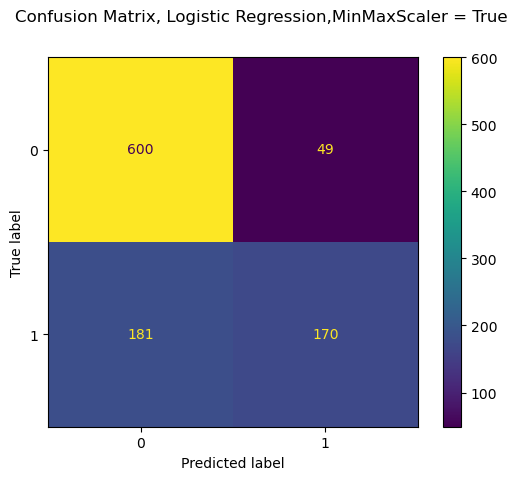

In [59]:
# re-re-run simple logistic regression on train/split of same 'reduced'
# 3-feature data using the same pipeline except WITH normalization (min-max scaling):
train_norm(X_red, y_red, normalize=True)

#### _Note on normalization/standardization pre-processing for logistic regression:_   
* The `scikit-learn` documentation states:  
> _While many algorithms (such as SVM, K-nearest neighbors, and logistic regression)  
require features to be normalized, intuitively we can think of Principle Component  
Analysis (PCA) as being a prime example of when normalization is important._  


* Apparently, _standardization_ isn't required for logistic regression, although  
it speeds convergence. However, some note that `sklearn.linear_model.LogisticRegression`  
uses L2-penalty by default (_that is, Ridge Regression), where standardization does  
matter._  


* In any case, none of the above attempts to normalize/standardize the original  
training data of 5,000 samples seems to make a difference in the poor predictive  
performance of simple logistic regression as measured by ***recall for purchase  
prediction***, which is what we are interested in here.


### _...OK, now resuming with LabelSpreading semi-supervised experiment:_  

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091

Confusion Matrix:
[[18562  1170]
 [ 5251  5108]]


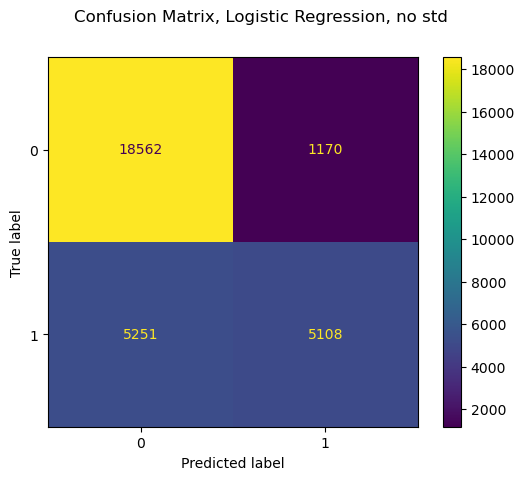

In [60]:
lr_model = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
lr_pred  = lr_model.predict(X_test)

# check performance report
print(classification_report(y_test, lr_pred))

# plot confusion matrix:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, lr_pred)
disp.figure_.suptitle(f'Confusion Matrix, Logistic Regression, no std')

print(f'Confusion Matrix:\n{disp.confusion_matrix}')

plt.show()

7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [61]:
X = np.concatenate((X_train, X_test), axis=0)
print(X.shape)

(35091, 3)


In [62]:
assert X.shape == (35091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [63]:
y_dtest = np.full(y_test.shape, -1)
y = np.concatenate((y_train, y_dtest), axis=0)
print(y.shape)
print(y)

(35091,)
[ 0  0  0 ... -1 -1 -1]


In [64]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [65]:
# train a LabelSpreading model:
ls_model = LabelSpreading(kernel='knn', alpha=0.01)  # NB: n_neighbors defaults to 7 here
ls_model.fit(X, y)

LabelSpreading(alpha=0.01, kernel='knn')

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [66]:
# check shape of ndarray transduction_ (label assigned to
# each item via the transduction):
ls_model.transduction_.shape

(35091,)

In [67]:
semi_sup_preds = ls_model.transduction_[X_train.shape[0]:]
print(semi_sup_preds.shape)

(30091,)


In [68]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     19732
           1       0.81      0.63      0.71     10359

    accuracy                           0.82     30091
   macro avg       0.82      0.78      0.79     30091
weighted avg       0.82      0.82      0.82     30091

Confusion Matrix:
[[18195  1537]
 [ 3810  6549]]


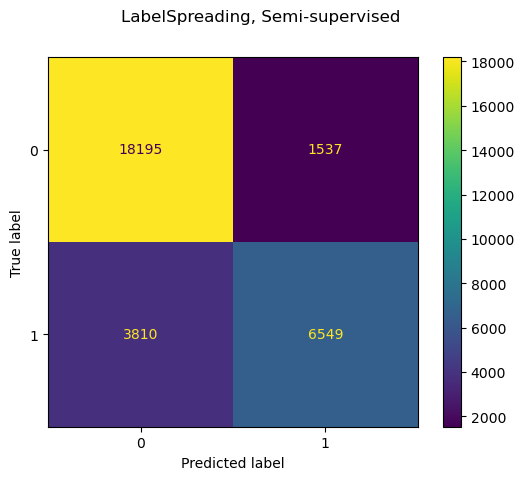

In [69]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

# plot confusion matrix:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, semi_sup_preds)
disp.figure_.suptitle(f'LabelSpreading, Semi-supervised')

print(f'Confusion Matrix:\n{disp.confusion_matrix}')

plt.show()

Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

              precision    recall  f1-score   support

           0       0.78      0.94      0.85     19732
           1       0.81      0.49      0.61     10359

    accuracy                           0.79     30091
   macro avg       0.80      0.72      0.73     30091
weighted avg       0.79      0.79      0.77     30091

Confusion Matrix:
[[18562  1170]
 [ 5251  5108]]


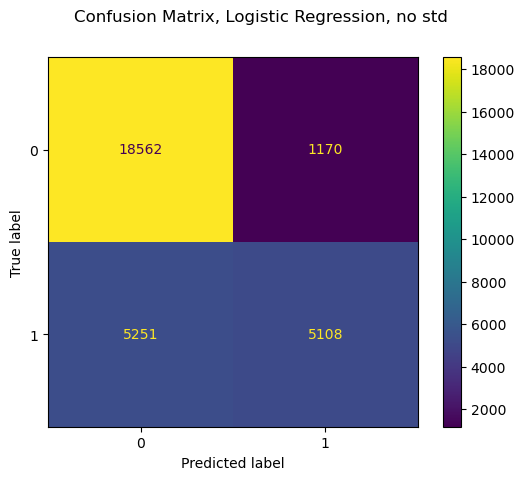

In [70]:
print(classification_report(y_test, lr_pred))

# plot confusion matrix:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, lr_pred)
disp.figure_.suptitle(f'Confusion Matrix, Logistic Regression, no std')

print(f'Confusion Matrix:\n{disp.confusion_matrix}')

plt.show()

### _Answer:_

...Interesting. The metric which is most improved by LabelSpreading semi-supervised  
learning (compared with logistic regression)  is **recall on purchases**, which is  
what we are interested in. _Still, our model performance (given the limited 3  
features available with the new cosmetic products) is not yet good enough to use  
for guidance on what to stock--Customers will be ***disappointed!***_   

_Why did LabelSpreading improve recall on purchases?_  
Apparently, it was able to _learn a better function_ mapping the given 3 features  
to the desired output of purchase prediction. LabelSpreading generates a _similarity  
matrix_ from training data and then propagates labels from labeled to unlabeled data.  
In contrast to LabelPropagation, LabelSpreading minimizes a loss function incorporating  
regularization that makes it more robust to noise (I don't understand the further  
details, but it follows a procedure also used in _Spectral clustering_.) There is also  
a _clamping factor,_ α, which allows the algorithm to change the weight of the true  
ground labeled data to a limited degree (in our case, we set this to 1%).  

The above implementation of LabelSpreading used the KNN kernel, which executed almost  
instantly. If time permitted, it would be interesting to experiment with the RBF kernel,  
which produces a 'fully connected graph' via a dense matrix in memory (which can be large  
and slow).

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)